In [1]:
from dask.distributed import Client, LocalCluster
import logging

cluster = LocalCluster(
    n_workers=28,
    threads_per_worker=8,
    silence_logs=logging.DEBUG
)

client = Client(cluster, heartbeat_interval=10000)
print(client.dashboard_link)

/opt/tljh/user/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36899 instead
  http_address["port"], self.http_server.port
distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:     tcp://127.0.0.1:41805
distributed.scheduler - INFO -   dashboard at:           127.0.0.1:36899
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:45751'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:44661'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:38487'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:45361'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:34257'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:42681'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:37779'
distributed.nanny - INFO -         

http://127.0.0.1:36899/status


In [2]:
import afqinsight as afqi
import beeswarm as bs
import joblib
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import pandas as pd
import pickle
import seaborn as sns

from datetime import datetime

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score

from skopt import BayesSearchCV
from skopt.plots import plot_convergence, plot_objective, plot_evaluations

print(afqi.__version__)

0.2.9.dev460469908


In [3]:
X, y, groups, columns, subjects, classes = afqi.load_afq_data(
    "../data/raw/als_data",
    target_cols=["class"],
    label_encode_cols=["class"],
)

In [4]:
label_sets = afqi.multicol2sets(pd.MultiIndex.from_tuples(columns, names=["metric", "tractID", "nodeID"]))

In [5]:
X_md_fa = afqi.select_groups(X, [["fa"], ["md"]], label_sets)

In [6]:
groups_md_fa = groups[:40]

In [7]:
def get_cv_results(n_repeats=5, n_splits=10,
                   power_transformer=False, 
                   shuffle=False,
                   ensembler=None,
                   n_estimators=10,
                   max_samples=1.0):
    if shuffle:
        rng = np.random.default_rng()
        y_fit = rng.permutation(y)
    else:
        y_fit = np.copy(y)

    cv = RepeatedStratifiedKFold(
        n_splits=n_splits,
        n_repeats=n_repeats,
        random_state=1729
    )

    cv_results = {}
    pipe_skopt = afqi.make_afq_classifier_pipeline(
        imputer_kwargs={"strategy": "median"},
        use_cv_estimator=True,
        power_transformer=power_transformer,
        scaler="standard",
        groups=groups_md_fa,
        verbose=0,
        pipeline_verbosity=False,
        tuning_strategy="bayes",
        cv=3,
        n_bayes_points=9,
        n_jobs=28,
        l1_ratio=[0.0, 1.0],
        eps=5e-2,
        n_alphas=100,
        ensemble_meta_estimator=ensembler,
        ensemble_meta_estimator_kwargs={
            "n_estimators": n_estimators,
            "n_jobs": 1,
            "oob_score": True,
            "random_state": 1729,
            "max_samples": max_samples,
        },
    )

    for cv_idx, (train_idx, test_idx) in enumerate(cv.split(X_md_fa, y_fit)):
        start = datetime.now()

        X_train, X_test = X_md_fa[train_idx], X_md_fa[test_idx]
        y_train, y_test = y_fit[train_idx], y_fit[test_idx]

        with joblib.parallel_backend("dask"):
            pipe_skopt.fit(X_train, y_train)

        cv_results[cv_idx] = {
            "pipeline": pipe_skopt,
            "train_idx": train_idx,
            "test_idx": test_idx,
            "y_prob": pipe_skopt.predict_proba(X_test)[:, 1],
            "y_pred": pipe_skopt.predict(X_test),
            "y_true": y_test,
            "test_accuracy": accuracy_score(y_test, pipe_skopt.predict(X_test)),
            "train_accuracy": accuracy_score(y_train, pipe_skopt.predict(X_train))
        }
        
        if ensembler is None:
            cv_results[cv_idx]["optimizer"] = pipe_skopt.named_steps["estimate"].bayes_optimizer_


        print(f"CV index [{cv_idx:3d}], Elapsed time: ", datetime.now() - start)
        
    return cv_results, y_fit

In [8]:
# results = {}
# results["no_power_transform"] = get_cv_results(
#     n_splits=10, n_repeats=5, power_transformer=False, shuffle=False
# )
# results["power_transform"] = get_cv_results(
#     n_splits=10, n_repeats=5, power_transformer=True, shuffle=False
# )

# results["shuffle_no_transform"] = get_cv_results(
#     n_splits=10, n_repeats=3, power_transformer=False, shuffle=True
# )
# results["shuffle_transform"] = get_cv_results(
#     n_splits=10, n_repeats=3, power_transformer=True, shuffle=True
# )

In [9]:
with open("als_classify.pkl", "rb") as fp:
    results = pickle.load(fp)

In [10]:
results.keys()

dict_keys(['no_power_transform', 'power_transform', 'shuffle_no_transform', 'shuffle_transform', 'bagging', 'bagging_shuffle', 'bagging_stratify', 'bagging_shuffle_stratify'])

In [11]:
for key, res in results.items():
    test_accuracies = [cvr["test_accuracy"] for cvr in res[0].values()]
    train_accuracies = [cvr["train_accuracy"] for cvr in res[0].values()]
    print(key, "test", np.mean(test_accuracies))
    print(key, "train", np.mean(train_accuracies))

no_power_transform test 0.828
no_power_transform train 1.0
power_transform test 0.7969999999999999
power_transform train 1.0
shuffle_no_transform test 0.5150000000000001
shuffle_no_transform train 0.9821881606765328
shuffle_transform test 0.5
shuffle_transform train 0.9790697674418605
bagging test 0.8400000000000001
bagging train 0.9838266384778013
bagging_shuffle test 0.5700000000000001
bagging_shuffle train 1.0
bagging_stratify test 0.8600000000000001
bagging_stratify train 0.993076109936575
bagging_shuffle_stratify test 0.495
bagging_shuffle_stratify train 0.9676532769556025


In [12]:
import itertools

def mean_over_combinations(results):
    length = len(results)
    mean_results = {}
    for r in range(1, length + 1):
        mean_results[r] = [
            np.mean([res["yhat"].values for res in comb], axis=0)
            for comb in itertools.combinations(results, r=r)
        ]
        
    return mean_results

def accuracy_over_combinations(results):
    mean_results = mean_over_combinations(results)
    mean_accuracies = []
    for r in mean_results.keys():
        mean_accuracies += [
            {
                "n_repeats": r,
                "accuracy": accuracy_score(results[0]["class"].values, res > 0.5)
            } for res in mean_results[r]
        ]
        
    return pd.DataFrame(mean_accuracies)

def auc_over_combinations(results):
    mean_results = mean_over_combinations(results)
    mean_auc = []
    for r in mean_results.keys():
        mean_auc += [
            {
                "n_repeats": r,
                "auc": roc_auc_score(results[0]["class"].values, res)
            } for res in mean_results[r]
        ]
        
    return pd.DataFrame(mean_auc)

def get_accuracy_ensemble_dataframe(cv_results, y_true):    
    test_probs = {
        idx: pd.Series(
            data=cvr["y_prob"],
            index=cvr["test_idx"],
            name="yhat"
        )
        for idx, cvr in cv_results.items()
    }
    
    df_ytest = {
        idx: pd.DataFrame(test_probs[idx]).merge(
            pd.DataFrame(y, columns=["class"]),
            left_index=True,
            right_index=True,
            how="left"
        ) for idx in test_probs.keys()
    }
    
    acc_scores = [
        accuracy_score(_df["class"].values, _df["yhat"].values > 0.5)
        for _df in df_ytest.values()
    ]
    
    repeats = [
        pd.concat([df_ytest[i] for i in range(x * 10, (x + 1) * 10)]).sort_index()
        for x in range(len(cv_results) // 10)
    ]
    
    return accuracy_over_combinations(repeats)

In [13]:
df_accuracies = {
    key: get_accuracy_ensemble_dataframe(res[0], y)
    for key, res in results.items()
}

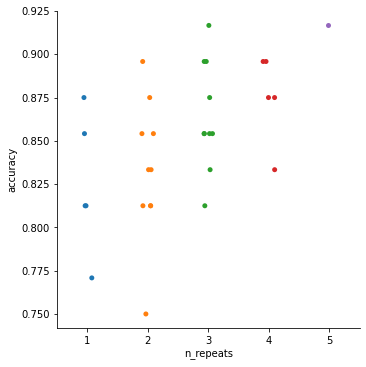

In [14]:
sns.catplot(x="n_repeats", y="accuracy", data=df_accuracies["no_power_transform"])

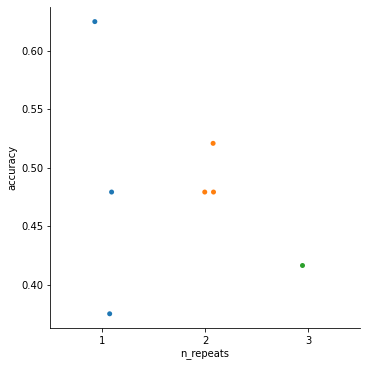

In [15]:
sns.catplot(x="n_repeats", y="accuracy", data=df_accuracies["shuffle_no_transform"])

In [16]:
# results["bagging_stratify"] = get_cv_results(
#     n_splits=10, n_repeats=1, power_transformer=False,
#     ensembler="serial-bagging", shuffle=False,
#     n_estimators=20
# )
# results["bagging_shuffle_stratify"] = get_cv_results(
#     n_splits=10, n_repeats=1, power_transformer=False,
#     ensembler="serial-bagging", shuffle=True
# )

In [17]:
for key, res in results.items():
    test_accuracies = [cvr["test_accuracy"] for cvr in res[0].values()]
    train_accuracies = [cvr["train_accuracy"] for cvr in res[0].values()]
    print(key, "test", np.mean(test_accuracies))
    print(key, "train", np.mean(train_accuracies))

no_power_transform test 0.828
no_power_transform train 1.0
power_transform test 0.7969999999999999
power_transform train 1.0
shuffle_no_transform test 0.5150000000000001
shuffle_no_transform train 0.9821881606765328
shuffle_transform test 0.5
shuffle_transform train 0.9790697674418605
bagging test 0.8400000000000001
bagging train 0.9838266384778013
bagging_shuffle test 0.5700000000000001
bagging_shuffle train 1.0
bagging_stratify test 0.8600000000000001
bagging_stratify train 0.993076109936575
bagging_shuffle_stratify test 0.495
bagging_shuffle_stratify train 0.9676532769556025


In [18]:
# with open("als_classify.pkl", "wb") as fp:
#     pickle.dump(results, fp)

In [19]:
bagging_results = results["bagging_stratify"][0]

In [20]:
bagging_results[0].keys()

dict_keys(['pipeline', 'train_idx', 'test_idx', 'y_prob', 'y_pred', 'y_true', 'test_accuracy', 'train_accuracy'])

In [21]:
nested_lists = [[
    est.coef_ for est in
    bag_res["pipeline"].named_steps["estimate"].estimators_
] for bag_res in bagging_results.values()]

coefs = [y for x in nested_lists for y in x]

In [22]:
np.array(coefs).shape

(200, 4000)

In [23]:
columns_md_fa = [
    c for c in columns
    if "fa" in c or "md" in c
]

In [24]:
from dipy.viz import window, actor, panel
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
from dipy.tracking.streamline import transform_streamlines
from dipy.viz import colormap
from dipy.viz import ui

import json

/opt/tljh/user/lib/python3.7/site-packages/dipy/viz/__init__.py:32: UserWarning: You do not have FURY installed. Some visualization functions might not work for you. For installation instructions, please visit: https://fury.gl/
  "You do not have FURY installed. "


ImportError: cannot import name 'window' from 'dipy.viz' (/opt/tljh/user/lib/python3.7/site-packages/dipy/viz/__init__.py)

In [ ]:
df_bag = pd.concat([
    pd.DataFrame.from_dict(
        {
            k: v for k, v in bag_res.items()
            if k in ["test_idx", "y_prob", "y_true"]
        }
    ).set_index(keys="test_idx", drop=True)
    for bag_res in bagging_results.values()
]).sort_index()
df_bag.head()

In [ ]:
df_bag["Ground truth"] = df_bag["y_true"].map({0: "Control", 1: "ALS"})
df_bag["y_pred"] = (df_bag["y_prob"] > 0.5).astype(int)
df_bag["Prediction"] = df_bag["y_pred"].map(
    {0: "Predicted control", 1: "Predicted ALS"}
)
df_bag.head()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.swarmplot(
    y="y_prob",
    x="Ground truth",
    hue="Prediction",
    data=df_bag,
    ax=ax,
    s=18
)

ax.set_ylabel("Classification probabilities", fontsize=18)
ax.set_xlabel("Ground truth", fontsize=18)
ax.legend(fontsize=18, markerscale=2)
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 12)
ax.axhline(0.5, ls="--", color="black")
print(accuracy_score(df_bag["y_true"], df_bag["y_pred"]))